In [ ]:
import pandas as pd
import random
import numpy as np
from random import randint
import torch
from transformers import AutoTokenizer, AutoModel
import gc

import scipy as sp
from scipy import sparse
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from openTSNE import TSNE, affinity

import matplotlib.pyplot as plt
import matplotlib

import time
import memory_profiler

%load_ext memory_profiler

from pathlib import Path

In [ ]:
torch.__version__

'1.8.1+cu111'

In [ ]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.model_stuff import train_loop_tsne_and_knn_rec, train_loop_eval_test_loss
from text_embeddings_src.data_stuff import (
    MultOverlappingSentencesPairDataset,
)
from text_embeddings_src.metrics import knn_accuracy
from text_embeddings_src.embeddings import generate_embeddings
from text_embeddings_src.plotting import (
    plot_label_tags,
    plot_tsne_colors,
    improved_coloring,
)

In [ ]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [ ]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../data")

In [ ]:
plt.style.use("matplotlib_style.txt")

In [ ]:
model = None
gc.collect()
torch.cuda.empty_cache()

# Import

## Data

In [ ]:
# %%time
# compression_opts = dict(method="zip", archive_name="iclr.pickle.csv")

# iclr = pd.read_pickle(
#     data_path / "iclr.pickle.zip",
#     # index_col=False,
#     compression=compression_opts,
# )

In [ ]:
iclr = pd.read_parquet(
    data_path / "iclr.parquet.gzip",
    # index=False,
    engine="pyarrow",
    # compression="gzip",
)

In [ ]:
iclr.keywords = iclr.keywords.transform(lambda x: list(x))
iclr.scores = iclr.scores.transform(lambda x: list(x))

In [ ]:
iclr

year           id                                              title  \
0      2018    ryBnUWb0b  Predicting Floor-Level for 911 Calls with Neur...   
1      2018    Skk3Jm96W  Some Considerations on Learning to Explore via...   
2      2018    r1RQdCg0W  MACH: Embarrassingly parallel $K$-class classi...   
3      2018    rJ3fy0k0Z  Deterministic Policy Imitation Gradient Algorithm   
4      2018    SkBYYyZRZ                 Searching for Activation Functions   
...     ...          ...                                                ...   
16531  2023   w4eQcMZsJa  Text-Driven Generative Domain Adaptation with ...   
16532  2023   SDHSQuBpf2  Laziness, Barren Plateau, and Noises in Machin...   
16533  2023  HyIY8u5LVDr  Discovering the Representation Bottleneck of G...   
16534  2023  470wZ5Qk4ur  Results for Perfect Classification for Graph A...   
16535  2023   3GDft6lexE  Cooperate or Compete: A New Perspective on Tra...   

                                                abstract  \
0      In cities with tall buildings, emergency respo...   
1      We consider the problem of exploration in meta...   
2      We present Merged-Averaged Classifiers via Has...   
3      The goal of imitation learning (IL) is to enab...   
4      The choice of activation functions in deep net...   
...                                                  ...   
16531  Combined with the generative prior of pre-trai...   
16532  We define \emph{laziness} to describe a large ...   
16533  Most graph neural networks (GNNs) rely on the ...   
16534  We study the ability of one layer Graph Attent...   
16535  GANs have two competing modules: the generator...   

                                                 authors  \
0                    William Falcon, Henning Schulzrinne   
1      Bradly Stadie, Ge Yang, Rein Houthooft, Xi Che...   
2        Qixuan Huang, Anshumali Shrivastava, Yiqiu Wang   
3                       Fumihiro Sasaki, Atsuo Kawaguchi   
4           Prajit Ramachandran, Barret Zoph, Quoc V. Le   
...                                                  ...   
16531  Zhenhuan Liu, Liang Li, Jiayu Xiao, Zhengjun Z...   
16532                              Zexi Lin, Liang Jiang   
16533  Fang Wu, Siyuan Li, Lirong Wu, Dragomir Radev,...   
16534                      Kimon Fountoulakis, Amit Levi   
16535                                        Sobhan Babu   

                       decision     scores  \
0               Accept (Poster)  [7, 6, 6]   
1      Invite to Workshop Track  [7, 4, 6]   
2                        Reject  [6, 6, 6]   
3                        Reject  [6, 5, 5]   
4      Invite to Workshop Track  [5, 4, 7]   
...                         ...        ...   
16531             Desk rejected         []   
16532             Desk rejected         []   
16533             Desk rejected         []   
16534             Desk rejected         []   
16535             Desk rejected         []   

                                                keywords gender-first  \
0      [recurrent neural networks, rnn, lstm, mobile ...         male   
1      [reinforcement learning, rl, exploration, meta...         male   
2      [extreme classification, large-scale learning,...         None   
3                                   [imitation learning]         None   
4                  [meta learning, activation functions]         None   
...                                                  ...          ...   
16531  [gan, stylegan, clip, domain adaptation, style...         None   
16532  [theoretical issues in deep learning, learning...         None   
16533  [gnn bottleneck, graph rewiring, representatio...         None   
16534                                                 []         None   
16535  [generative adversarial networks, nash equilib...         None   

      gender-last    t-SNE x    t-SNE y  
0            None   2.536470   0.739367  
1            male  49.831927 -29.813831  
2            None -22.502752   9.577367  
3            None 

In [ ]:
titles_abstracts_together = [
    iclr.title[i] + " " + iclr.abstract[i] for i in range(len(iclr))
]

In [ ]:
print(len(titles_abstracts_together))

16536


## Labels

In [ ]:
# iclr = pd.read_pickle("iclr.pickle.zip")

keywords = [
    "network",
    "graph",
    "reinforcement",
    "language",
    "adversarial",
    "federated",
    "contrastive",
    "domain",
    "diffusion",
    "out-of-dis",
    "continual",
    "distillation",
    "architecture",
    "privacy",
    "protein",
    "fair",
    "attention",
    "video",
    "meta-learning",
    "generative adv",
    "autoencoder",
    "game",
    "semi-sup",
    "pruning",
    "physics",
    "3d",
    "translation",
    "optimization",
    "recurrent",
    "word",
    "bayesian",
]
keywords = np.array(keywords)

y = np.zeros(iclr.shape[0]) * np.nan

for num, keyword in enumerate(keywords):
    mask = [keyword.lower() in t.lower() for t in iclr.title]
    y[mask & ~np.isnan(y)] = -1
    y[mask & np.isnan(y)] = num

print(y.size)
print(np.sum(~np.isnan(y)))
print(np.sum(y >= 0))

labeled = y >= 0

iclr_labeled = iclr[labeled].reset_index(drop=True)
y_labeled = y[labeled].astype(int)
iclr_labeled["y"] = y_labeled
iclr_labeled["label"] = keywords[y_labeled]

16536
8964
6849


#### Colors

In [ ]:
keywords = [
    "network",
    "graph",
    "reinforcement",
    "language",
    "adversarial",
    "federated",
    "contrastive",
    "domain",
    "diffusion",
    "out-of-dis",
    "continual",
    "distillation",
    "architecture",
    "privacy",
    "protein",
    "fair",
    "attention",
    "video",
    "meta-learning",
    "generative adv",
    "autoencoder",
    "game",
    "semi-sup",
    "pruning",
    "physics",
    "3d",
    "translation",
    "optimization",
    "recurrent",
    "word",
    "bayesian",
]
keywords = np.array(keywords)

# glasbey.create_palette(palette_size=32)
labelColors = [
    "#d21820",
    "#1869ff",
    "#008a00",
    "#f36dff",
    "#710079",
    "#aafb00",
    "#00bec2",
    "#ffa235",
    "#5d3d04",
    "#08008a",
    "#005d5d",
    "#9a7d82",
    "#a2aeff",
    "#96b675",
    "#9e28ff",
    "#4d0014",
    "#ffaebe",
    "#ce0092",
    "#00ffb6",
    "#002d00",
    "#9e7500",
    "#3d3541",
    "#f3eb92",
    "#65618a",
    "#8a3d4d",
    "#5904ba",
    "#558a71",
    "#b2bec2",
    "#ff5d82",
    "#1cc600",
    "#92f7ff",
    "#2d86a6",
]
labelColors = np.array(labelColors)

dict_colors = dict(zip(keywords, labelColors))

In [ ]:
# correct the 3d to 3D for my color creation method
dict_colors["3D"] = dict_colors["3d"]
dict_colors.pop("3d")

'#5904ba'

In [ ]:
# change optimization color
dict_colors["optimization"] = "#8b4513"

In [ ]:
dict_colors

{'network': '#d21820',
 'graph': '#1869ff',
 'reinforcement': '#008a00',
 'language': '#f36dff',
 'adversarial': '#710079',
 'federated': '#aafb00',
 'contrastive': '#00bec2',
 'domain': '#ffa235',
 'diffusion': '#5d3d04',
 'out-of-dis': '#08008a',
 'continual': '#005d5d',
 'distillation': '#9a7d82',
 'architecture': '#a2aeff',
 'privacy': '#96b675',
 'protein': '#9e28ff',
 'fair': '#4d0014',
 'attention': '#ffaebe',
 'video': '#ce0092',
 'meta-learning': '#00ffb6',
 'generative adv': '#002d00',
 'autoencoder': '#9e7500',
 'game': '#3d3541',
 'semi-sup': '#f3eb92',
 'pruning': '#65618a',
 'physics': '#8a3d4d',
 'translation': '#558a71',
 'optimization': '#8b4513',
 'recurrent': '#ff5d82',
 'word': '#1cc600',
 'bayesian': '#92f7ff',
 '3D': '#5904ba'}

In [ ]:
labels_with_unlabeled, colors = improved_coloring(iclr["title"], dict_colors)

# Training

## Training run21
Optimize the [av] representation for 10 epochs for BERT, MPNET, and SBERT. batch_size=64, lr=2e-5.

Now using the multi sentence data augmentation (MultOverlappingSentencesPairDataset), with n_cons_sntcs=2

Now I do two forms of evaluation isntead of knn accuracy:
- do t-SNE using the representations of ater 1 epoch and after 10 epochs
- kNN recall in which the "original high-dim" representation is the space trained after 10 epochs and the "low-dim" one is after one epoch

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    print("Model: ", model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )
    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, tsne_embeddings, knn_recall = train_loop_tsne_and_knn_rec(
        model,
        training_loader,
        device,
        titles_abstracts_together,
        tokenizer,
        optimized_rep="av",
        n_epochs=10,
        lr=2e-5,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower())
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(variables_path / saving_path / "losses_run21", losses)
    np.save(
        variables_path / saving_path / "tsne_embeddings_run21",
        tsne_embeddings,
    )
    np.save(variables_path / saving_path / "knn_recall_run21", knn_recall)

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  BERT
Running on device: cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-uncased


  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetModel: ['lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing MPNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

microsoft/mpnet-base


  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

### Plot

#### Losses 

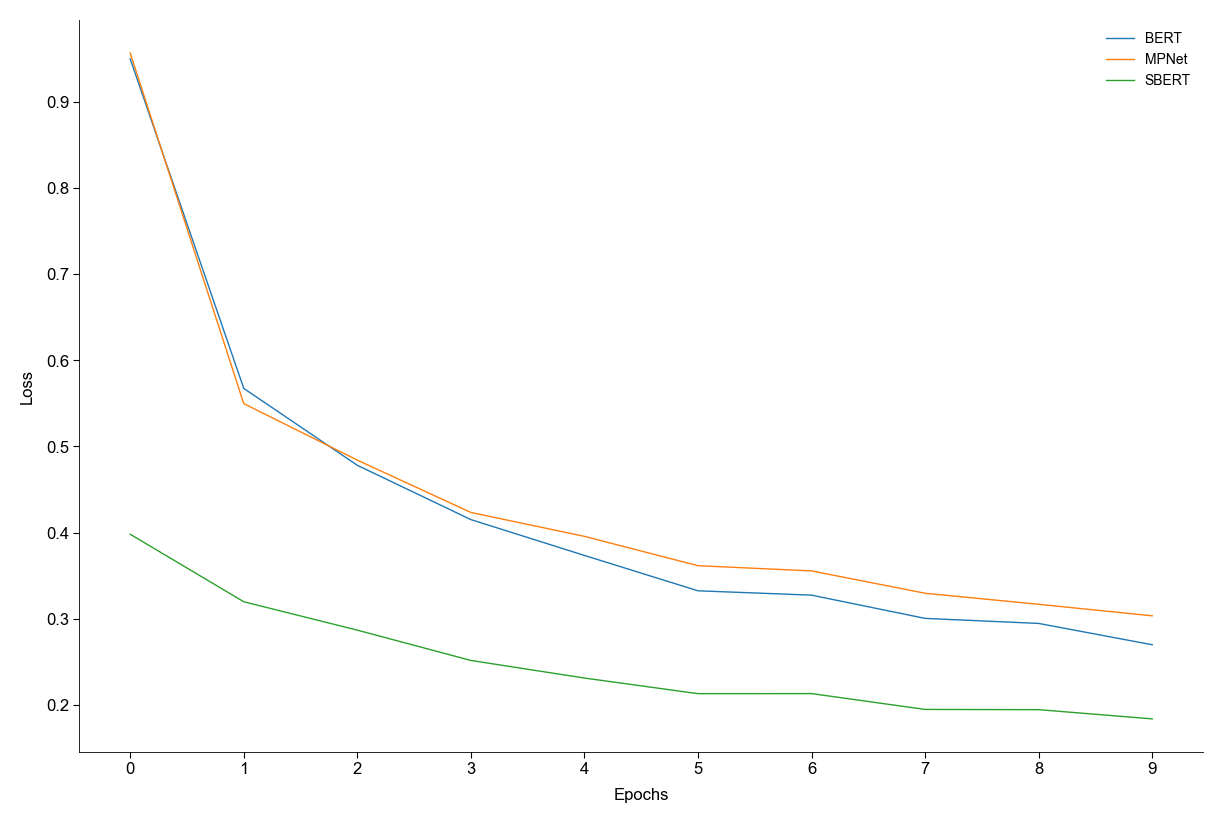

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(figsize=(6, 4), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower())
    losses = np.load(variables_path / saving_path / "losses_run21.npy")

    color = colormap(i)

    axs.plot(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label=model_name,
        color=color,
    )
    axs.set_xticks(np.arange(n_epochs))
    axs.set_xlabel("Epochs")
    axs.set_ylabel("Loss")
    axs.legend()

fig.savefig(figures_path / "loss_training_run21_v1.png")

#### t-SNE's

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [ ]:
# knn recall
for i, model_name in enumerate(model_names):
    saving_path = Path("embeddings_" + model_name.lower())
    knn_recall = np.load(variables_path / saving_path / "knn_recall_run21.npy")
    print(f"kNN recall for {model_name}: {knn_recall[0]:.3f}")

kNN recall for BERT: 0.520
kNN recall for MPNet: 0.568
kNN recall for SBERT: 0.674


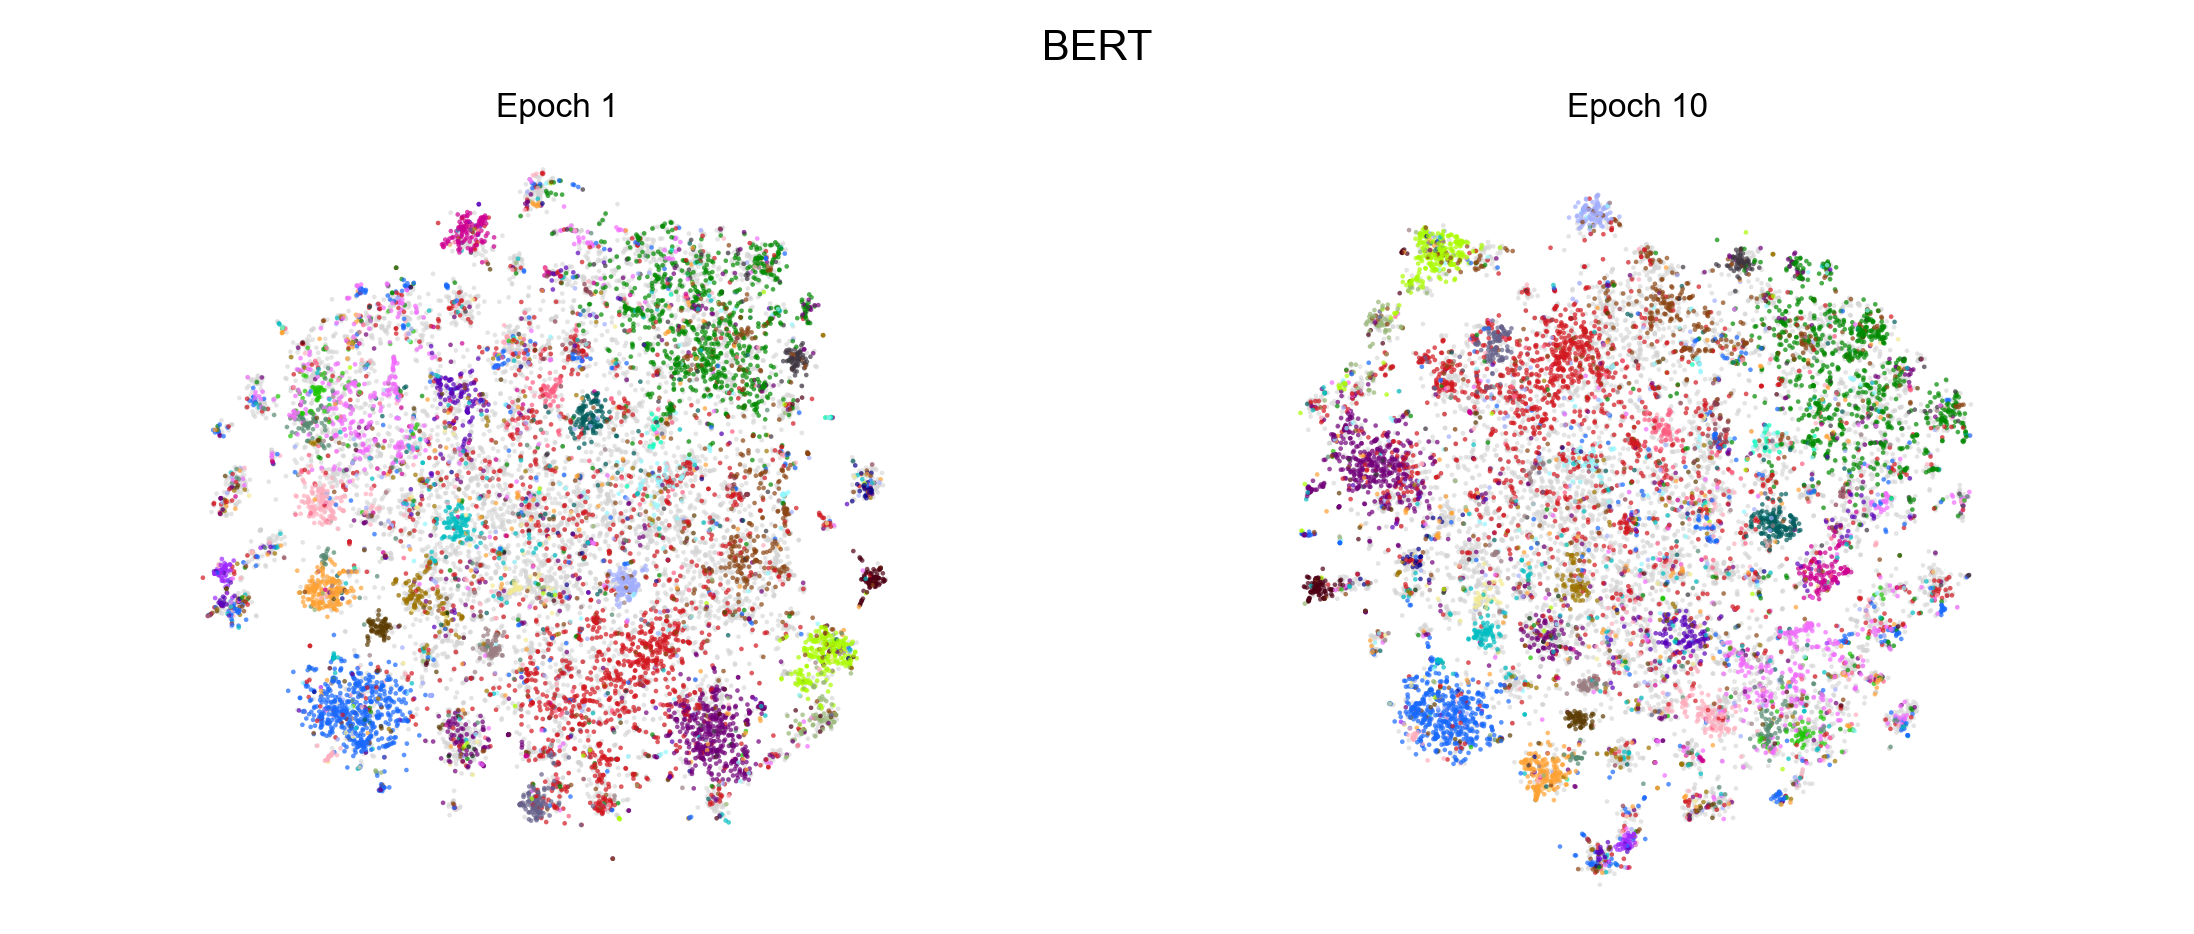

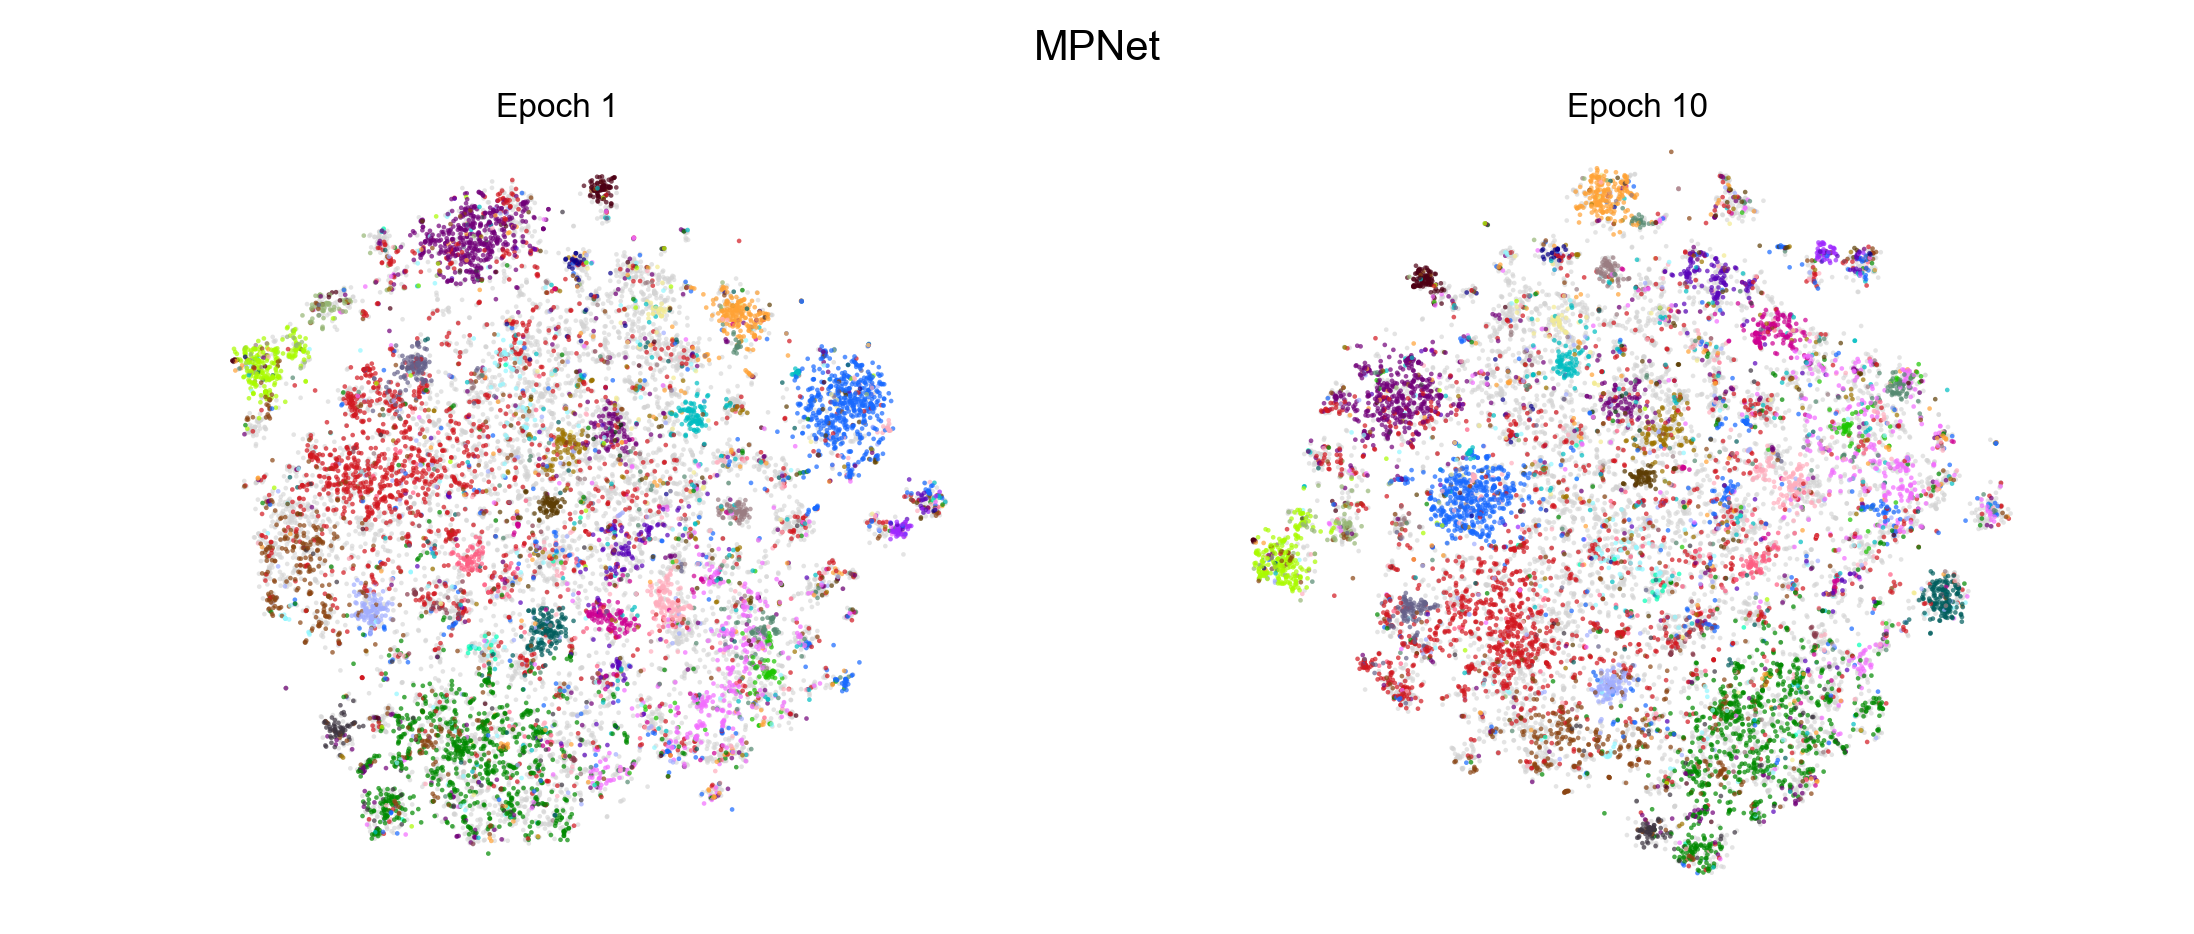

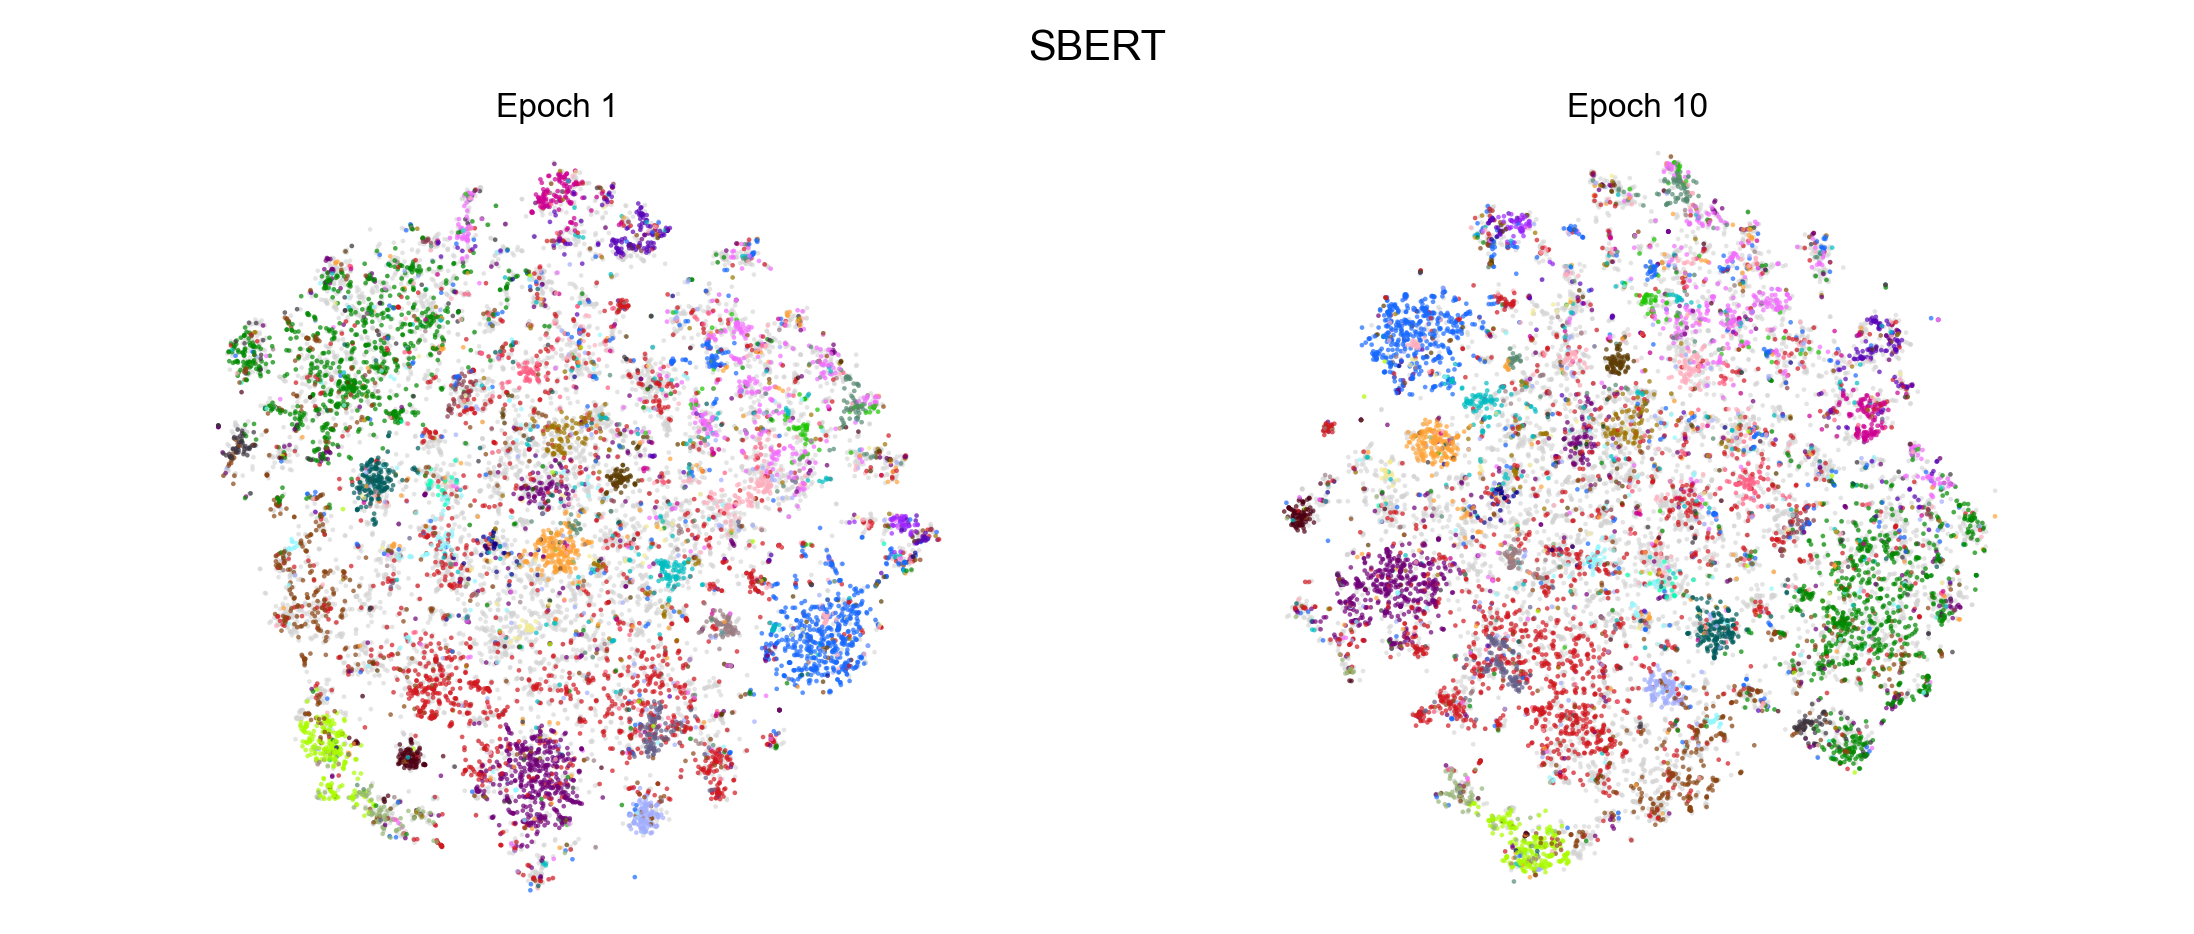

In [ ]:
for i, model_name in enumerate(model_names):
    fig, ax = plt.subplots(1, 2, figsize=(7.2, 3), dpi=300)
    xlim = (-70, 70)
    ylim = (-70, 70)

    # import tsne
    saving_path = Path("embeddings_" + model_name.lower())
    tsne_embeddings = np.load(
        variables_path / saving_path / "tsne_embeddings_run21.npy"
    )

    # 1
    plot_tsne_colors(
        tsne_embeddings[0], colors, ax=ax[0], x_lim=xlim, y_lim=ylim
    )
    # plot_label_tags(
    #     tsne_svd_n_comp_100,
    #     colors,
    #     dict_colors,
    #     x_lim=xlim,
    #     y_lim=ylim,
    #     ax=ax[0],
    #     subset=False,
    #     fontsize=6,
    # )
    ax[0].set_title("Epoch 1")

    # 2
    plot_tsne_colors(
        tsne_embeddings[1], colors, ax=ax[1], x_lim=xlim, y_lim=ylim
    )
    # plot_label_tags(
    #     tsne_svd_n_comp_100,
    #     colors,
    #     dict_colors,
    #     x_lim=xlim,
    #     y_lim=ylim,
    #     ax=ax[1],
    #     subset=False,
    #     fontsize=6,
    # )
    ax[1].set_title(f"Epoch {n_epochs}")

    fig.suptitle(f"{model_name}", fontsize=10)

    fig.savefig(figures_path / f"tsne_{model_name}_epoch_1_and_10_run21.png")

##### Figure Dmitry

In [ ]:
?plt.subplots

Signature:
plt.subplots(
    nrows: 'int' = 1,
    ncols: 'int' = 1,
    *,
    sharex: "bool | Literal['none', 'all', 'row', 'col']" = False,
    sharey: "bool | Literal['none', 'all', 'row', 'col']" = False,
    squeeze: 'bool' = True,
    width_ratios: 'Sequence[float] | None' = None,
    height_ratios: 'Sequence[float] | None' = None,
    subplot_kw: 'dict[str, Any] | None' = None,
    gridspec_kw: 'dict[str, Any] | None' = None,
    **fig_kw,
) -> 'tuple[Figure, Any]'
Docstring:
Create a figure and a set of subplots.

This utility wrapper makes it convenient to create common layouts of
subplots, including the enclosing figure object, in a single call.

Parameters
----------
nrows, ncols : int, default: 1
    Number of rows/columns of the subplot grid.

sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
    Controls sharing of properties among x (*sharex*) or y (*sharey*)
    axes:

    - True or 'all': x- or y-axis will be shared among all subplots.
    - False

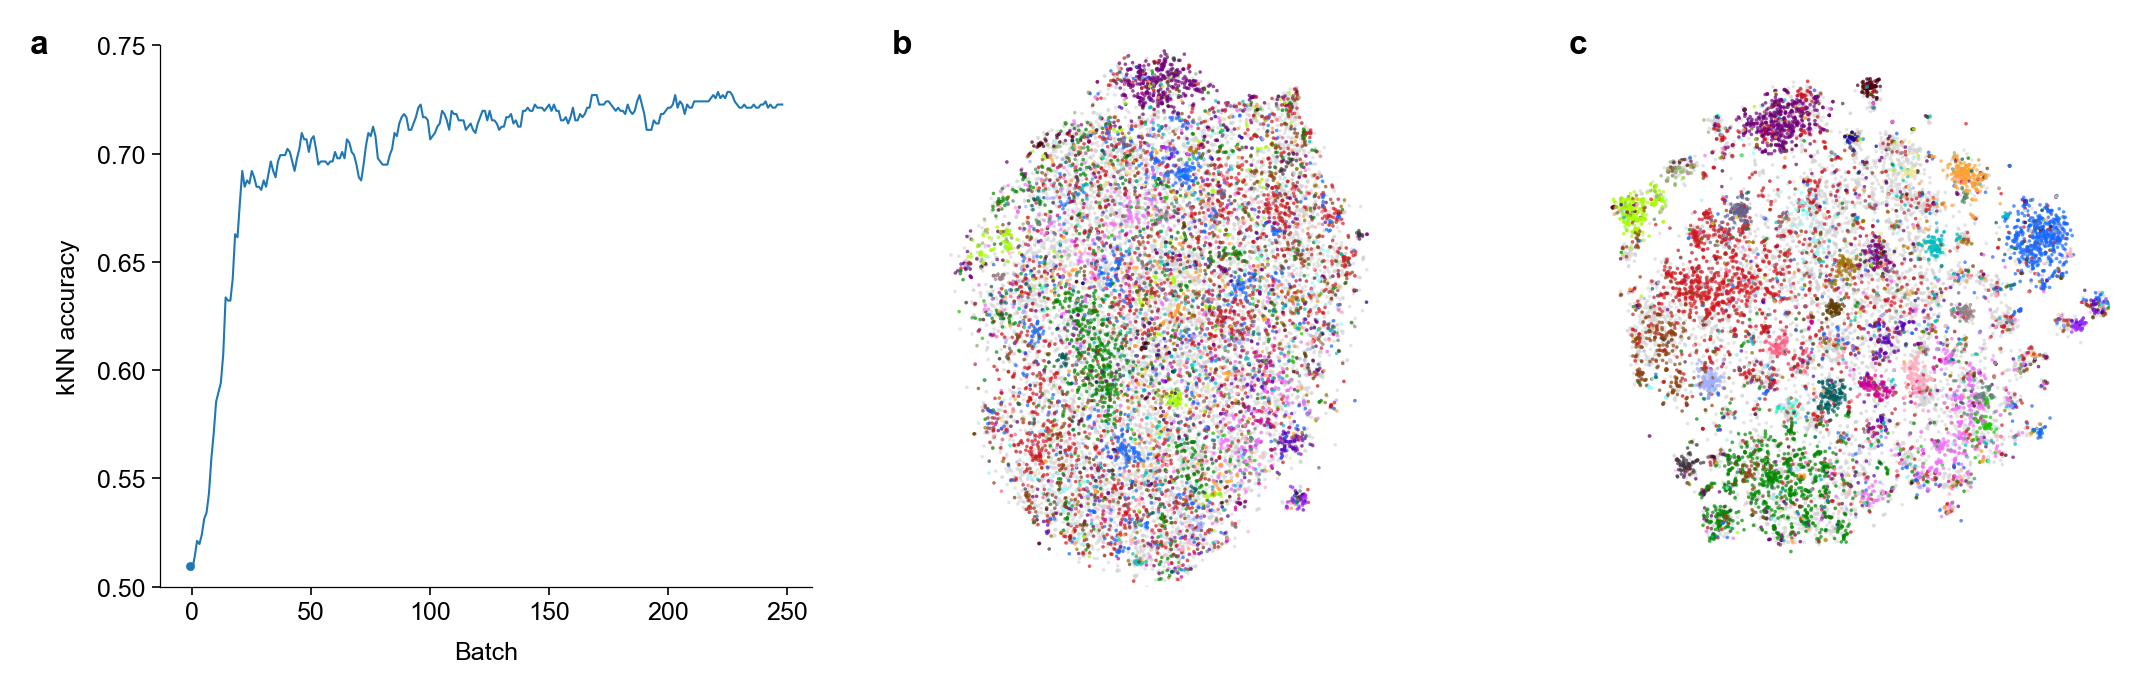

In [ ]:
import string

fig, ax = plt.subplots(
    1,
    3,
    figsize=(7.2, 2.2),
    dpi=300,
    layout="constrained",
    # width_ratios=[0.3, 0.35, 0.35],  # [0.4, 0.3, 0.3],  #
)


i = 0
model_name = model_names[i]
txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

## import tsne
# a
saving_name_2 = Path("knn_accuracy_" + "bert" + ".npy")
knn_acc_highd = np.load(variables_path / saving_name_2)

saving_path = Path("embeddings_" + model_name.lower())

knn_accuracies_iclr = np.load(
    variables_path
    / saving_path
    / "knn_accuracies_batches_train_iclr_eval_iclr_v1.npy",
)
# before
i = 1
model_name = model_names[i]
saving_path = Path("embeddings_" + model_name.lower())
tsne_name = "tsne_av.npy"
tsne_before = np.load(variables_path / saving_path / tsne_name)

# after
tsne_embeddings = np.load(
    variables_path / saving_path / "tsne_embeddings_run21.npy"
)


###PLOT
## a
ax[0].plot(
    np.arange(249),
    np.vstack(knn_accuracies_iclr)[:, 1],
    label="ICLR",
    c="tab:blue",
)
ax[0].scatter(-1, knn_acc_highd[1], c="tab:blue", s=5)
ax[0].set_ylim(0.5, 0.75)
ax[0].set_xlabel("Batch")
ax[0].set_ylabel("kNN accuracy")
ax[0].text(
    -0.2,
    1.03,
    string.ascii_lowercase[0],
    transform=ax[0].transAxes,
    **txtkwargs,
)

## Before training
xlim = (-55, 55)
ylim = (-55, 55)
plot_tsne_colors(
    np.vstack((tsne_before[:, 1], -tsne_before[:, 0])).T,
    colors,
    ax=ax[1],
    x_lim=xlim,
    y_lim=ylim,
    # axis_on=True,
    plot_type="subplot_3",
)
ax[1].text(
    0, 1.03, string.ascii_lowercase[1], transform=ax[1].transAxes, **txtkwargs
)


## After 1 epoch
xlim = (-70, 70)
ylim = (-70, 70)
plot_tsne_colors(
    tsne_embeddings[0],
    colors,
    ax=ax[2],
    x_lim=xlim,
    y_lim=ylim,
    # axis_on=True,
    plot_type="subplot_3",
)
ax[2].text(
    0, 1.03, string.ascii_lowercase[2], transform=ax[2].transAxes, **txtkwargs
)


fig.savefig(figures_path / f"tsne_{model_name}_before_after_training_v2.png")

## Training run22
Optimize the [av] representation for 10 epochs for BERT, MPNET, and SBERT. batch_size=64, lr=2e-5.

Now using the multi sentence data augmentation (MultOverlappingSentencesPairDataset), with n_cons_sntcs=2

Now I do:
- Only train the model on the train set and evaluate after each epoch the test set by computing the loss.  
- "abstract-accuracy": use as dataset now instead of abtsracts, sentences of abstracts and as labels the abstract PMID. 

In [ ]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    ## set up model
    print("Model: ", model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    ## data
    # split into train and test
    X_train, X_test = train_test_split(
        iclr.abstract, test_size=0.1, random_state=np.random.seed(seed)
    )

    # do the train and test datasets with the class
    n_cons_sntcs = 2

    train_dataset = MultOverlappingSentencesPairDataset(
        X_train, tokenizer, device, n_cons_sntcs=n_cons_sntcs, seed=42
    )
    test_dataset = MultOverlappingSentencesPairDataset(
        X_test, tokenizer, device, n_cons_sntcs=n_cons_sntcs, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(seed)

    # do the loader with the train and test datasets
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=64, shuffle=True, generator=gen
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    (
        losses_train,
        losses_test,
        knn_accuracies_abstract_train,
        knn_accuracies_abstract_test,
    ) = train_loop_eval_test_loss(
        model,
        train_loader,
        test_loader,
        device,
        tokenizer,
        train_dataset,
        test_dataset,
        optimized_rep="av",
        n_epochs=10,
        lr=2e-5,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower())
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(variables_path / saving_path / "losses_train_run22", losses_train)
    np.save(variables_path / saving_path / "losses_test_run22", losses_test)

    np.save(
        variables_path / saving_path / "knn_accuracies_abstract_train_run22",
        knn_accuracies_abstract_train,
    )
    np.save(
        variables_path / saving_path / "knn_accuracies_abstract_test_run22",
        knn_accuracies_abstract_test,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  BERT
Running on device: cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-uncased


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/31 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/31 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/31 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/31 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/31 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/31 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/31 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/31 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/31 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/31 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetModel: ['lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing MPNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

microsoft/mpnet-base


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/31 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/31 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/31 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/31 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/31 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [ ]:
print(len(train_dataset))
print(len(test_dataset))
print(len(train_dataset) * 0.1)
print(len(test_dataset) * 0.1)

14345
1586
1434.5
158.60000000000002


### Plot

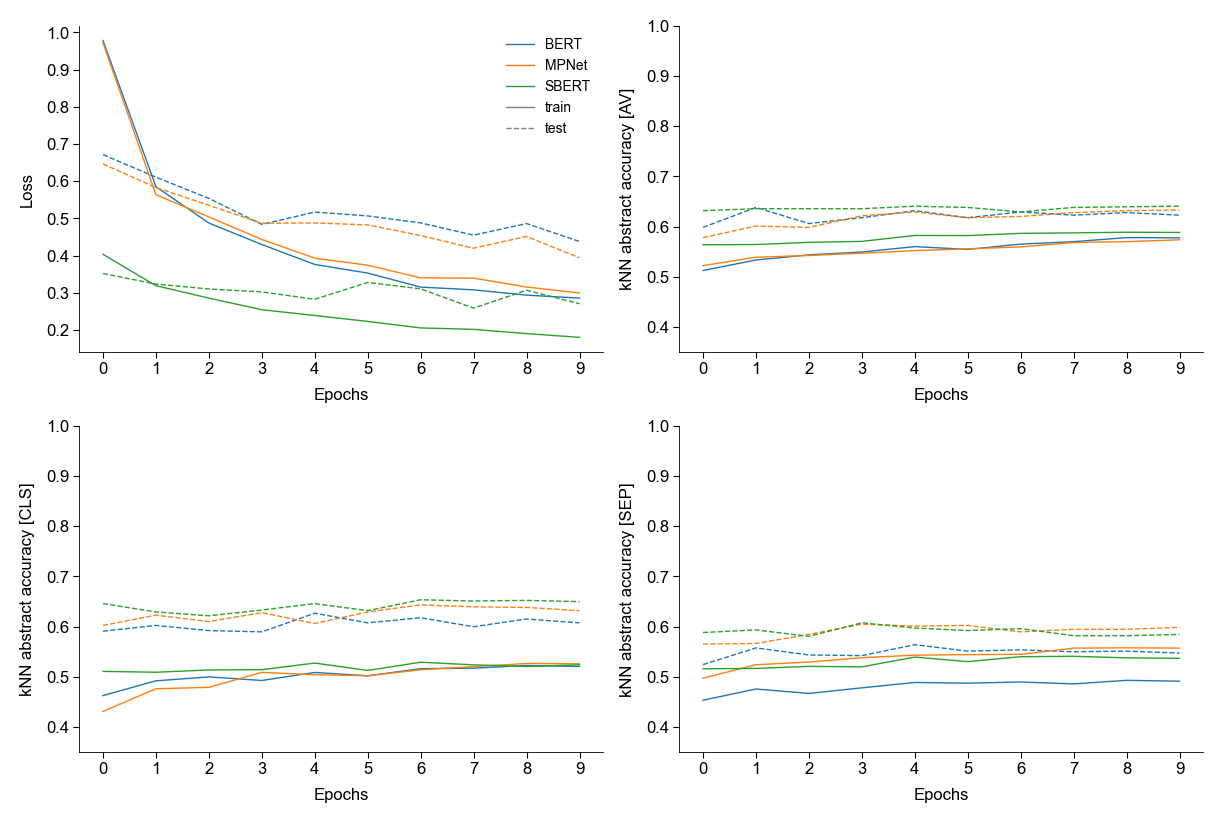

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 10
colormap = plt.get_cmap("tab10")

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower())

    losses_train = np.load(
        variables_path / saving_path / "losses_train_run22.npy"
    )
    losses_test = np.load(
        variables_path / saving_path / "losses_test_run22.npy"
    )
    knn_accuracies_train = np.load(
        variables_path
        / saving_path
        / "knn_accuracies_abstract_train_run22.npy"
    )
    knn_accuracies_test = np.load(
        variables_path / saving_path / "knn_accuracies_abstract_test_run22.npy"
    )

    color = colormap(i)

    axs[0, 0].plot(
        np.arange(n_epochs),
        np.mean(losses_train, axis=1),
        label=model_name,
        color=color,
        ls="-",
    )
    axs[0, 0].plot(
        np.arange(n_epochs),
        np.mean(losses_test, axis=1),
        # label=model_name,
        color=color,
        ls="--",
    )
    # legend of train and test
    if i == len(model_names) - 1:
        line_train = axs[0, 0].plot([], [], c="grey", ls="-", label="train")
        line_test = axs[0, 0].plot([], [], c="grey", ls="--", label="test")
    axs[0, 0].set_xticks(np.arange(n_epochs))
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()

    axs[0, 1].plot(
        np.arange(n_epochs),
        knn_accuracies_train[:, 0],
        # label=f"{knn_accuracies[-1, 0]:.3f}",
        color=color,
        ls="-",
    )
    axs[0, 1].plot(
        np.arange(n_epochs),
        knn_accuracies_test[:, 0],
        # label=f"{knn_accuracies[-1, 0]:.3f}",
        color=color,
        ls="--",
    )
    # axs[0, 1].text(
    #     -0.3,
    #     knn_acc_highd[0],
    #     f"{knn_acc_highd[0]:.3f}",
    #     fontsize=5,
    #     va="center",
    #     ha="left",
    # )
    # axs[0, 1].legend()
    axs[0, 1].set_xticks(np.arange(n_epochs))
    axs[0, 1].set_ylim(0.35, 1)
    axs[0, 1].set_xlabel("Epochs")
    axs[0, 1].set_ylabel("kNN abstract accuracy [AV]")

    axs[1, 0].plot(
        np.arange(n_epochs),
        knn_accuracies_train[:, 1],
        label=model_name,
        color=color,
        ls="-",
    )
    axs[1, 0].plot(
        np.arange(n_epochs),
        knn_accuracies_test[:, 1],
        label=model_name,
        color=color,
        ls="--",
    )
    axs[1, 0].set_xticks(np.arange(n_epochs))
    axs[1, 0].set_ylim(0.35, 1)
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 0].set_ylabel("kNN abstract accuracy [CLS]")

    axs[1, 1].plot(
        np.arange(n_epochs),
        knn_accuracies_train[:, 2],
        label=model_name,
        color=color,
        ls="-",
    )
    axs[1, 1].plot(
        np.arange(n_epochs),
        knn_accuracies_test[:, 2],
        label=model_name,
        color=color,
        ls="--",
    )
    axs[1, 1].set_xticks(np.arange(n_epochs))
    axs[1, 1].set_ylim(0.35, 1)
    axs[1, 1].set_xlabel("Epochs")
    axs[1, 1].set_ylabel("kNN abstract accuracy [SEP]")

fig.savefig(figures_path / "loss_and_knn_accuracy_eval_test_run22_v3.png")

### Sanity check
Rerun for 1 model for another train-test split to see if the contradictory result from loss vs knn abstract accuracy is due to the specific train-test partition.
Before it was using rs=42, now rs=23

In [ ]:
model_names = [
    "BERT",
    # "MPNet",
    # "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    # "microsoft/mpnet-base",
    # "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    ## set up model
    print("Model: ", model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    ## data
    # split into train and test
    X_train, X_test = train_test_split(
        iclr.abstract, test_size=0.1, random_state=np.random.seed(23)
    )

    # do the train and test datasets with the class
    n_cons_sntcs = 2

    train_dataset = MultOverlappingSentencesPairDataset(
        X_train, tokenizer, device, n_cons_sntcs=n_cons_sntcs, seed=42
    )
    test_dataset = MultOverlappingSentencesPairDataset(
        X_test, tokenizer, device, n_cons_sntcs=n_cons_sntcs, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(seed)

    # do the loader with the train and test datasets
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=64, shuffle=True, generator=gen
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    (
        losses_train,
        losses_test,
        knn_accuracies_abstract_train,
        knn_accuracies_abstract_test,
    ) = train_loop_eval_test_loss(
        model,
        train_loader,
        test_loader,
        device,
        tokenizer,
        train_dataset,
        test_dataset,
        optimized_rep="av",
        n_epochs=5,
        lr=2e-5,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower())
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(
        variables_path / saving_path / "losses_train_sanity_check_run22",
        losses_train,
    )
    np.save(
        variables_path / saving_path / "losses_test_sanity_check_run22",
        losses_test,
    )

    np.save(
        variables_path
        / saving_path
        / "knn_accuracies_abstract_train_sanity_check_run22",
        knn_accuracies_abstract_train,
    )
    np.save(
        variables_path
        / saving_path
        / "knn_accuracies_abstract_test_sanity_check_run22",
        knn_accuracies_abstract_test,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  BERT
Running on device: cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-uncased


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/31 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/31 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/31 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/31 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/275 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/31 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

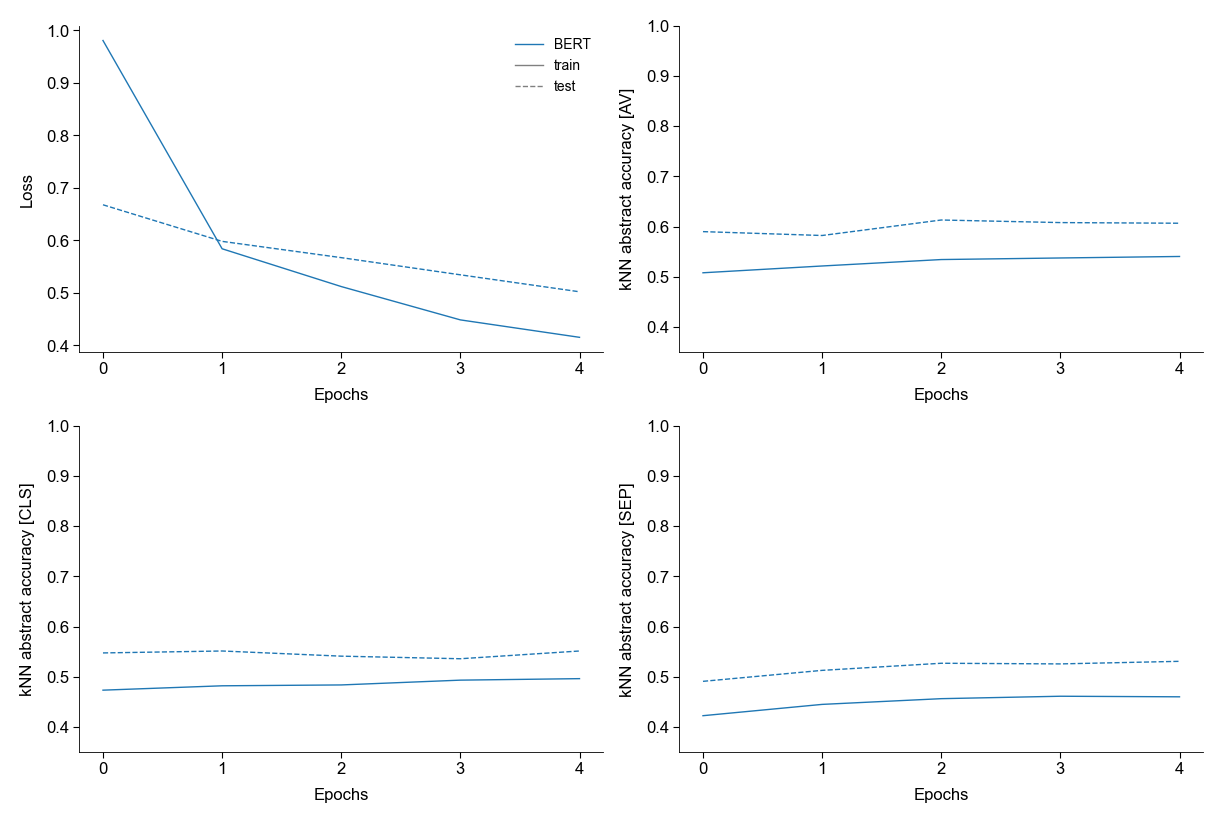

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 5
colormap = plt.get_cmap("tab10")

for i, model_name in enumerate(model_names):
    # load things
    saving_path = Path("embeddings_" + model_name.lower())

    losses_train = np.load(
        variables_path / saving_path / "losses_train_sanity_check_run22.npy"
    )
    losses_test = np.load(
        variables_path / saving_path / "losses_test_sanity_check_run22.npy"
    )
    knn_accuracies_train = np.load(
        variables_path
        / saving_path
        / "knn_accuracies_abstract_train_sanity_check_run22.npy"
    )
    knn_accuracies_test = np.load(
        variables_path
        / saving_path
        / "knn_accuracies_abstract_test_sanity_check_run22.npy"
    )

    color = colormap(i)

    axs[0, 0].plot(
        np.arange(n_epochs),
        np.mean(losses_train, axis=1),
        label=model_name,
        color=color,
        ls="-",
    )
    axs[0, 0].plot(
        np.arange(n_epochs),
        np.mean(losses_test, axis=1),
        # label=model_name,
        color=color,
        ls="--",
    )
    # legend of train and test
    if i == len(model_names) - 1:
        line_train = axs[0, 0].plot([], [], c="grey", ls="-", label="train")
        line_test = axs[0, 0].plot([], [], c="grey", ls="--", label="test")
    axs[0, 0].set_xticks(np.arange(n_epochs))
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()

    axs[0, 1].plot(
        np.arange(n_epochs),
        knn_accuracies_train[:, 0],
        # label=f"{knn_accuracies[-1, 0]:.3f}",
        color=color,
        ls="-",
    )
    axs[0, 1].plot(
        np.arange(n_epochs),
        knn_accuracies_test[:, 0],
        # label=f"{knn_accuracies[-1, 0]:.3f}",
        color=color,
        ls="--",
    )
    # axs[0, 1].text(
    #     -0.3,
    #     knn_acc_highd[0],
    #     f"{knn_acc_highd[0]:.3f}",
    #     fontsize=5,
    #     va="center",
    #     ha="left",
    # )
    # axs[0, 1].legend()
    axs[0, 1].set_xticks(np.arange(n_epochs))
    axs[0, 1].set_ylim(0.35, 1)
    axs[0, 1].set_xlabel("Epochs")
    axs[0, 1].set_ylabel("kNN abstract accuracy [AV]")

    axs[1, 0].plot(
        np.arange(n_epochs),
        knn_accuracies_train[:, 1],
        label=model_name,
        color=color,
        ls="-",
    )
    axs[1, 0].plot(
        np.arange(n_epochs),
        knn_accuracies_test[:, 1],
        label=model_name,
        color=color,
        ls="--",
    )
    axs[1, 0].set_xticks(np.arange(n_epochs))
    axs[1, 0].set_ylim(0.35, 1)
    axs[1, 0].set_xlabel("Epochs")
    axs[1, 0].set_ylabel("kNN abstract accuracy [CLS]")

    axs[1, 1].plot(
        np.arange(n_epochs),
        knn_accuracies_train[:, 2],
        label=model_name,
        color=color,
        ls="-",
    )
    axs[1, 1].plot(
        np.arange(n_epochs),
        knn_accuracies_test[:, 2],
        label=model_name,
        color=color,
        ls="--",
    )
    axs[1, 1].set_xticks(np.arange(n_epochs))
    axs[1, 1].set_ylim(0.35, 1)
    axs[1, 1].set_xlabel("Epochs")
    axs[1, 1].set_ylabel("kNN abstract accuracy [SEP]")

fig.savefig(
    figures_path / "loss_and_knn_accuracy_eval_test_sanity_check_run22_v1.png"
)